## Setup

In [75]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()

%output size=150
dims = SimpleNamespace(E_t=holoviews.Dimension(r'$E/t$'),
                       mu_t=holoviews.Dimension(r'$\mu/t$'),
                       lambda_=holoviews.Dimension(r'$\lambda$'),
                       x=holoviews.Dimension(r'$x$'),
                       k=holoviews.Dimension(r'$k$'),
                       amplitude=holoviews.Dimension(r'$|u|^2 + |v|^2$'))

holoviews.core.dimension.title_format = ''


Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex, MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment, spectrum, plot_bands, h_k, pauli


Press this button to show/hide the code used in the notebook:

## SSH chain

In [76]:
def ssh_chain(L=None, periodic=False, xi=None):
    '''
    L is the number of biatomic unit cells, 2L is the number of atoms
    xi is a matrix to mix into the on-site Hamiltonian.
    '''
    # two monatomic sublattices
    lat1 = kwant.lattice.chain(name='L1')
    lat2 = kwant.lattice.chain(name='L2')

    if L is None:
        sys = kwant.Builder(kwant.TranslationalSymmetry((-1,)))
        L = 1
    else:
        sys = kwant.Builder()

    # transformation to antisymmetric basis
    U = np.array([[1.0, 1.0], [1.j, -1.j]]) / np.sqrt(2)

    # on-site energy mu unchanged from Kitaev unless we break time.
    def onsite(onsite, p): 
        if xi is None:
            return - p.mu * U.dot(pauli.sz.dot(U.T.conj()))
        else:
            return (- (1 - p.alpha) * p.mu * U.dot(pauli.sz.dot(U.T.conj()))
                    + p.alpha * xi)
    
    for x in range(L):
        # create on site energies for BOTH sublattices
        sys[lat1(x)] = onsite
        sys[lat2(x)] = onsite

    def hop_t1(site1, site2, p):
        return U.dot((-p.t1 * pauli.sz - 1j * p.delta * pauli.sy).dot(U.T.conj()))
    
    def hop_t2(site1, site2, p):
        return U.dot((-p.t2 * pauli.sz - 1j * p.delta * pauli.sy).dot(U.T.conj()))
    
    #        SUBLATTICE STRUCTURE & HOPPING ENERGIES
    #
    #     :: the |n> label atoms, the m label unit cells.
    #     :: L1 and L2 are the sublattices
    #     :: "X" marks atoms. "|" marks unit cell boundaries.
    #        
    #   L1       L2   |   L1       L2   |   L1       L2
    #   m-1      m-1  |    m        m   |   m+1      m+1
    #                 |                 |
    #
    #  ~ X ~ t2 ~ X ~ t1 ~ X ~ t2 ~ X ~ t1 ~ X ~ t2 ~ X ~
    #   
    #           |2n-1>    |2n>    |2n+1>
    
    #sys[kwant.HoppingKind((1,), lat)] = hop
    # NB: delta defined as (a.tag - b.tag) !
    sys[kwant.HoppingKind((0,), lat1, lat2)] = hop_t2
    sys[kwant.HoppingKind((1,), lat1, lat2)] = hop_t1
    

    if periodic:
        raise NotImplemented
        
        def last_hop(site1, site2, p):
            return hop(site1, site2, p) * (1 - 2 * p.lambda_)
        
        sys[lat(0), lat(L - 1)] = last_hop
    return sys


### E($t_2$) spectrum with various $\mu$

b':HoloMap   [$\\mu/t$]\n   :Path   [$t_2/t_1$,$E/t$]'
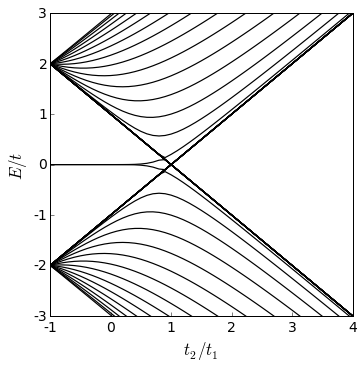
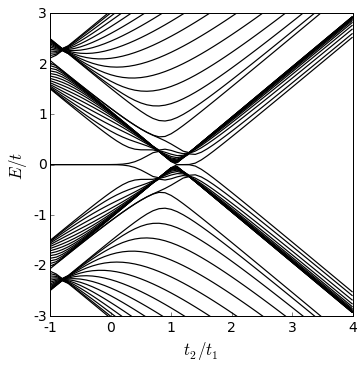
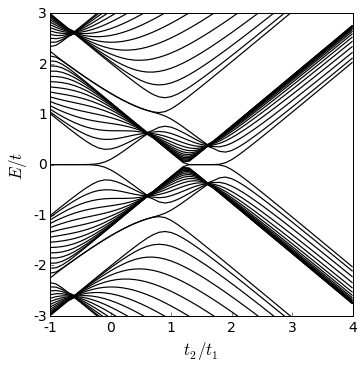
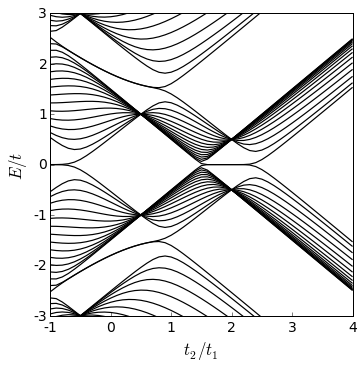
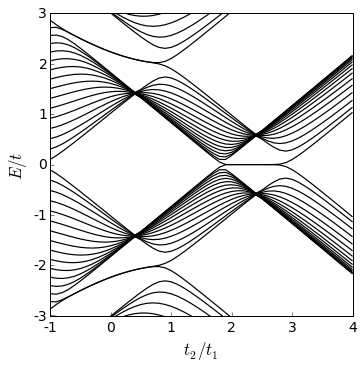
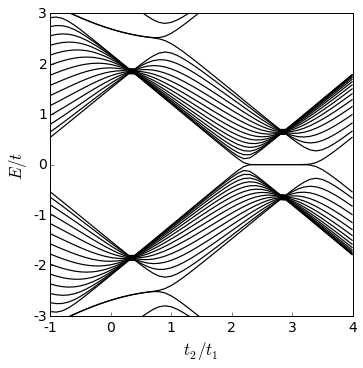
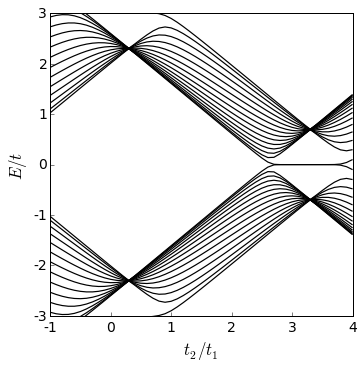

In [85]:
sys = ssh_chain(L=15).finalized()
t2s = np.arange(-1, 4.1, .1)
mus = np.arange(0, 3.5, .5)
holoviews.HoloMap (
    dict ((mu, spectrum(sys, t1=1, delta=1, mu=mu, t2=t2s, xticks=range(-1, 5), yticks=range(-3, 4), 
              xdim='$t_2/t_1$', ydim=dims.E_t))
       for mu in mus),
    kdims= [dims.mu_t])


### E($\mu$) spectrum with various $t_2$

b':HoloMap   [$t_2/t_1$]\n   :Path   [$\\mu/t$,$E/t$]'
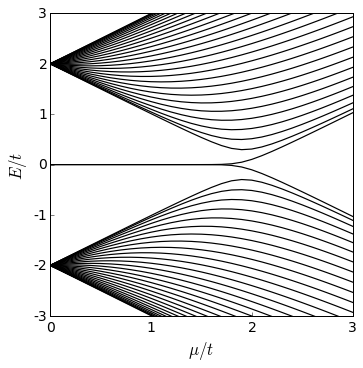
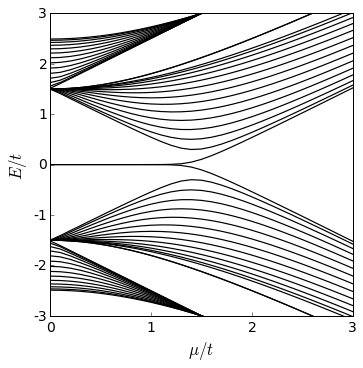
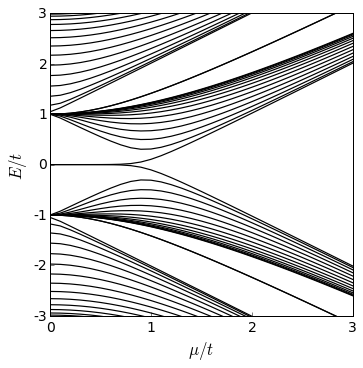
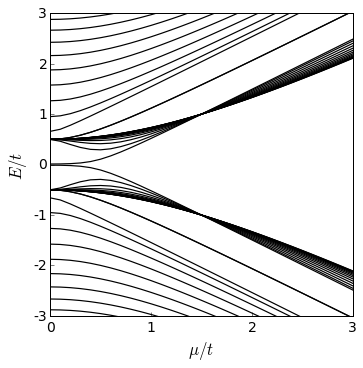
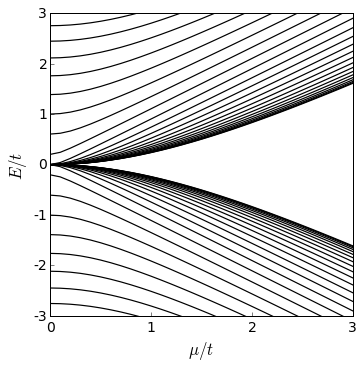
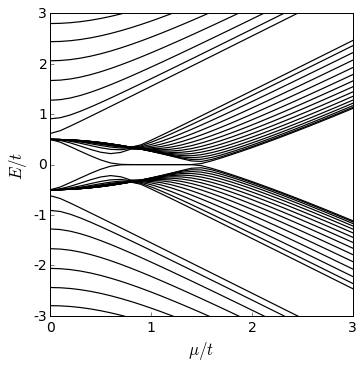
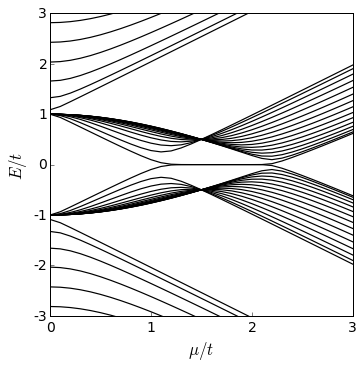
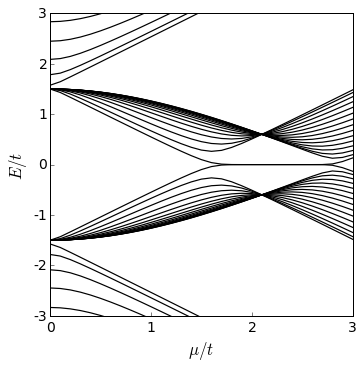
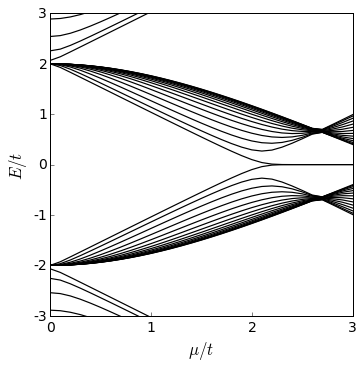
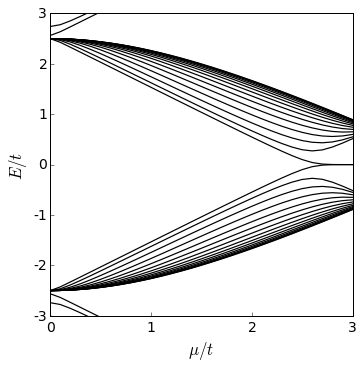
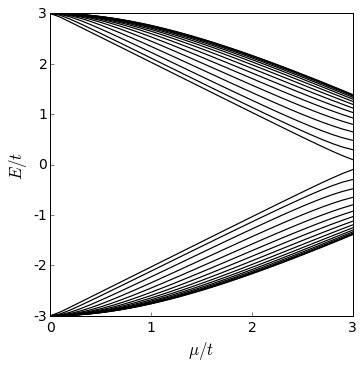

In [84]:
sys = ssh_chain(L=15).finalized()
t2s = np.arange(-1, 4.1, .5)
mus = np.arange(0, 3.2, .1)

holoviews.HoloMap (
    dict ((t2, spectrum(sys, t1=1, delta=1, mu=mus, t2=t2, xticks=range(0, 4), yticks=range(-3, 4), 
              xdim=dims.mu_t, ydim=dims.E_t))
       for t2 in t2s),
    kdims= ['$t_2/t_1$'])

### Messing with symmetry

There's nothing to be done about particle-hole symmetry, but what happens if we break **time-reversal symmetry** by adding a random complex Hamiltonian $\xi$ to the on-site energy, $H_\mathrm{site} = \big( (1-\alpha) \mu \tau_z + \alpha \xi \big) \left|n\right\rangle\left\langle n \right|$?

b':HoloMap   [$\\alpha$]\n   :Path   [$t_2/t_1$,$E/t$]'
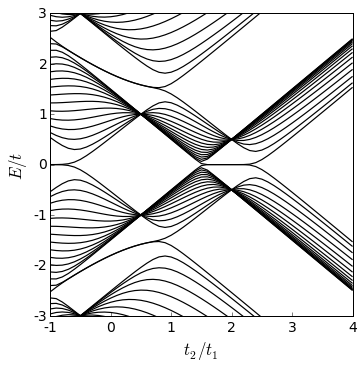
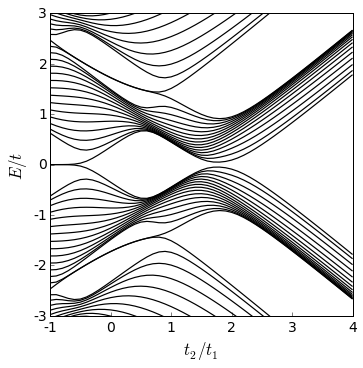
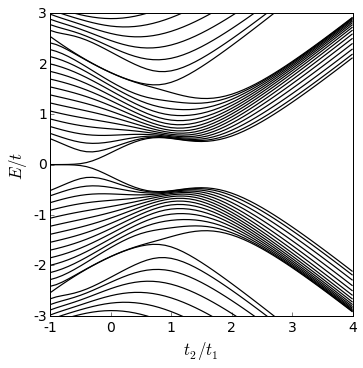
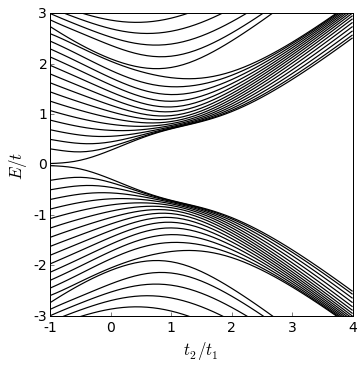
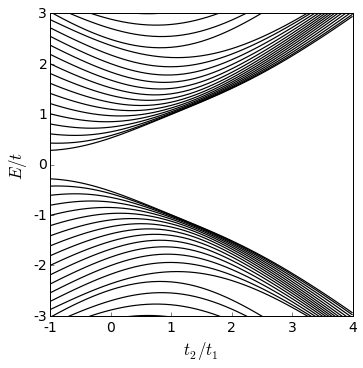

In [87]:
np.random.seed(1848)
xi = np.random.randn(2,2) + 1j * np.random.randn(2,2)
xi += xi.T.conj()
# normalize
xi /= np.sqrt(np.linalg.det(xi))
# give it a nice value.
xi *= 3
alphas = np.arange(0, 1, .2)
mu0 = 1.5

sys = ssh_chain(L=15, xi=xi).finalized()
t2s = np.arange(-1, 4.1, .1)
holoviews.HoloMap (
    dict ((alpha, spectrum(sys, t1=1, delta=1, mu=mu0, alpha=alpha, t2=t2s, xticks=range(-1, 5), yticks=range(-3, 4), 
              xdim='$t_2/t_1$', ydim=dims.E_t))
       for alpha in alphas),
    kdims= [r'$\alpha$'])

Time reversal may be crucial (but I'm not sure what else I may have broken apart from T symmetry in this model).